# Exercícios com Storytelling — SVM, Árvores de Decisão, Florestas Aleatórias e Boosting

**Objetivo:** Este notebook gera datasets sintéticos reprodutíveis e apresenta 12 exercícios com storytelling. Inclui uma seção de teoria sobre **Boosting** (AdaBoost, Gradient Boosting, XGBoost) comparando com Random Forest, SVM e Árvores.

**Reprodutibilidade:** `numpy.random.seed(42)` e `random.seed(42)`.
**Arquivos de dados:** serão salvos em `/mnt/data` quando você executar a célula de geração.


## 00. Teoria — Boosting em detalhe (AdaBoost, Gradient Boosting, XGBoost) e comparação crítica

**Boosting** combina **modelos fracos** (geralmente árvores rasas) de forma **sequencial e aditiva**, focando iterativamente nos **erros** anteriores.  
- **Bagging (Random Forest)**: modelos treinados **em paralelo** em *bootstraps*, reduzindo **variância**.  
- **Boosting**: em geral reduz **viés**, podendo aumentar variância se mal regularizado.

### AdaBoost (Freund & Schapire, 1997)
- Repondera exemplos, aumentando o peso dos mal classificados; agrega fracos-aprendizes por soma ponderada.  
- Sensível a **ruído de rótulo**; regularize com `learning_rate` menor e limite `n_estimators`.

### Gradient Boosting (Friedman, 2001)
- Vê boosting como **descida de gradiente funcional** em espaço de funções.  
- Ajusta árvores aos **pseudo-gradientes** da perda (ex.: log-loss para classificação).  
- Mais estável que AdaBoost em dados ruidosos; variantes suportam **subamostragem** e **early stopping**.

### XGBoost
- Otimizações (paralelismo, esparsidade) + **regularização L1/L2**.  
- Hiperparâmetros: `learning_rate`, `n_estimators`, `max_depth`, `subsample`, `colsample_bytree`, `reg_lambda`, `reg_alpha`.  
- Use **early stopping** com validação.

### Tabela comparativa
| Aspecto | Boosting | Random Forest (Bagging) | SVM | Árvore |
|---|---|---|---|---|
| Treino | Sequencial | Paralelo (bootstraps) | Otimiza margem | Guloso |
| Viés/Variância | ↓Viés (↑Variância se mal tunado) | ↓Variância | Depende de kernel/C | Alto viés/variância sem poda |
| Ruído de rótulo | Sensível (Ada) / Moderado (GBM) | Robusta moderada | Sensível a outliers (sem slack) | Sensível |
| Escala | Pouco sensível (árvores) | Pouco sensível | **Muito sensível** | Pouco sensível |
| Interpretabilidade | Média (SHAP/imp.) | Média (imp.) | Baixa (RBF) | **Alta** |
| Tuning | **Crítico** | Moderado | **Crítico** | Baixo–moderado |

**Boas práticas:** learning rate pequeno + mais árvores; subsample/colsample; early stopping; métricas adequadas em minoria (AUC-PR); calibração quando necessário.


## 0. Geração de Datasets
Execute a célula abaixo **uma vez** para criar todos os CSVs em `/mnt/data`.

In [ ]:

# Geração dos 12 datasets
import numpy as np, pandas as pd, os, random
from sklearn.datasets import make_classification, make_circles

np.random.seed(42); random.seed(42)
out_dir = "/mnt/data"; os.makedirs(out_dir, exist_ok=True)

def save(df, name): df.to_csv(f"{out_dir}/{name}", index=False)

# 1
X1, y1 = make_circles(n_samples=300, noise=0.10, factor=0.5, random_state=42)
df = pd.DataFrame(X1, columns=["proteina_A","proteina_B"]); df["resposta"]=y1.astype(int); save(df, "01_imunoterapia_circulos.csv")

# 2
X2, y2 = make_classification(n_samples=300, n_features=500, n_informative=15, n_redundant=10, n_classes=3, class_sep=1.2, random_state=42)
genes=[f"gene_{i}" for i in range(1,501)]; df=pd.DataFrame(X2, columns=genes); df["tratamento"]=pd.Series(y2).map({0:"A",1:"B",2:"C"}); save(df,"02_ratinhos_expressao_500genes.csv")

# 3
comprimento=np.random.normal(10,2,200); largura=np.random.normal(3,0.8,200); razao=comprimento/largura; mutante=(razao>3.2).astype(int)
df=pd.DataFrame({"comprimento":comprimento,"largura":largura,"razao_LW":razao,"mutante":mutante}); save(df,"03_folhas_morfometria.csv")

# 4
n=200; peso=np.clip(np.random.normal(22,9,n),3,60); idade=np.clip(np.random.normal(7.5,3.2,n),0.4,16); freq=np.clip(np.random.normal(95,18,n),50,180); t4=np.clip(np.random.normal(1.8,0.6,n),0.1,5)
diagnostico=(((t4<1.2)&(idade>7))|(freq<70)).astype(int); flip=np.random.choice(n,size=int(0.1*n),replace=False); diagnostico[flip]=1-diagnostico[flip]
df=pd.DataFrame({"peso":peso,"idade":idade,"frequencia_cardiaca":freq,"t4_serico":t4,"diagnostico":diagnostico}); save(df,"04_caes_hipotireoidismo.csv")

# 5
X5,y5=make_classification(n_samples=400,n_features=10000,n_informative=30,n_redundant=0,n_clusters_per_class=2,class_sep=1.0,random_state=42)
df=pd.DataFrame(X5,columns=[f"gene_{i}" for i in range(1,10001)]); df["diagnostico"]=y5.astype(int); save(df,"05_alzheimer_10000genes.csv")

# 6
n=300; temperatura=np.random.normal(15,5,n); polen=np.random.normal(120,40,n); acarose=np.random.normal(10,3,n); umidade=np.random.normal(60,10,n)
sobreviveu=((polen>100)&(acarose<12)).astype(int); flip=np.random.choice(n,size=int(0.08*n),replace=False); sobreviveu[flip]=1-sobreviveu[flip]
df=pd.DataFrame({"temperatura_media":temperatura,"polen":polen,"acarose":acarose,"umidade":umidade,"sobreviveu":sobreviveu}); save(df,"06_abelhas_sobrevivencia.csv")

# 7
X7,y7=make_classification(n_samples=300,n_features=10,n_informative=8,n_redundant=0,n_classes=3,class_sep=1.0,random_state=42)
df=pd.DataFrame(X7,columns=[f"gene_res{chr(65+i)}" for i in range(10)]); df["classe_resistencia"]=pd.Series(y7).map({0:"A",1:"B",2:"C"}); save(df,"07_ecoli_resistencia.csv")

# 8
n=250; idade=np.random.randint(25,81,n); col=np.random.normal(200,40,n); press=np.random.normal(120,15,n); bmi=np.random.normal(27,4,n); tabag=np.random.choice([0,1],size=n,p=[0.7,0.3])
risco=((idade>55)&(col>240)|((press>135)&(bmi>30))).astype(int); df=pd.DataFrame({"idade":idade,"colesterol":col,"pressao":press,"bmi":bmi,"tabagismo":tabag,"risco":risco}); save(df,"08_risco_cardiovascular.csv")

# 9
X9,y9=make_classification(n_samples=300,n_features=3,n_informative=3,n_redundant=0,n_classes=2,flip_y=0.15,random_state=42)
df=pd.DataFrame(X9,columns=["glicose","variabilidade_sensorial","ruido"]); df["paciente_id"]=np.random.randint(1000,2000,300); df["alerta"]=y9.astype(int)
df=df[["paciente_id","glicose","variabilidade_sensorial","ruido","alerta"]]; save(df,"09_sensor_glicose_ruido.csv")

# 10
X10,y10=make_classification(n_samples=500,n_features=20,n_informative=10,n_redundant=5,n_classes=2,class_sep=1.0,random_state=42)
df=pd.DataFrame(X10,columns=[f"var_{i}" for i in range(1,21)]); df["mortalidade"]=y10.astype(int); save(df,"10_uti_mortalidade_20vars.csv")

# B1
Xb1,yb1=make_classification(n_samples=1000,n_features=12,n_informative=6,weights=[0.97,0.03],n_classes=2,random_state=42)
df=pd.DataFrame(Xb1,columns=[f"var_{i}" for i in range(1,13)]); df["doenca_rara"]=yb1.astype(int); save(df,"B1_doenca_rara_desbalanceado.csv")

# B2
Xb2,yb2=make_classification(n_samples=200,n_features=500,n_informative=60,n_redundant=20,n_classes=4,class_sep=1.2,random_state=42)
df=pd.DataFrame(Xb2,columns=[f"snp_{i}" for i in range(1,501)]); df["origem"]=pd.Series(yb2).map({0:"AFR",1:"AMR",2:"EAS",3:"EUR"}); save(df,"B2_genomas_snps_500.csv")

print('Arquivos gerados em /mnt/data.')


Arquivos gerados em /mnt/data.


### 0.1 Demonstração — AdaBoost (dataset B1: doença rara)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, classification_report
import pandas as pd

# Dataset de doença rara (3% positivos)
df = pd.read_csv('/mnt/data/B1_doenca_rara_desbalanceado.csv')
X = df.drop(columns=['doenca_rara']).values
y = df['doenca_rara'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# OBS: nas versões recentes, use "estimator=" e não "base_estimator="
clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=400,
    learning_rate=0.1,
    random_state=42
)

clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

print("AUC-PR (classe positiva rara):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

AUC-PR (classe positiva rara): 0.34524146497830704
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       241
           1      0.000     0.000     0.000         9

    accuracy                          0.964       250
   macro avg      0.482     0.500     0.491       250
weighted avg      0.929     0.964     0.946       250



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 0.2 Demonstração — Gradient Boosting (dataset 10: UTI)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd

df = pd.read_csv('/mnt/data/10_uti_mortalidade_20vars.csv')
X = df.drop(columns=['mortalidade']).values
y = df['mortalidade'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

gbm = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=400,
    max_depth=3,
    random_state=42
)
gbm.fit(X_train, y_train)

y_proba = gbm.predict_proba(X_test)[:,1]
y_pred = gbm.predict(X_test)

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ROC AUC: 0.9554531490015361
              precision    recall  f1-score   support

           0      0.964     0.871     0.915        62
           1      0.884     0.968     0.924        63

    accuracy                          0.920       125
   macro avg      0.924     0.920     0.920       125
weighted avg      0.924     0.920     0.920       125



## 1. O Diagnóstico Impossível — SVM Linear vs. RBF

**Contexto:** Classificar resposta à imunoterapia a partir de proteínas séricas (`proteina_A`, `proteina_B`).

**Arquivo:** `/mnt/data/01_imunoterapia_circulos.csv`

**Tarefas:**

1) Treine SVM linear e SVM com kernel RBF.

2) Compare graficamente as fronteiras de decisão.

3) Explique (em linguagem biomédica) hiperplano e vetores de suporte.

**Métrica sugerida:** Acurácia e visualização 2D.


Acurácia (Linear): 0.453
Acurácia (RBF)   : 1.000


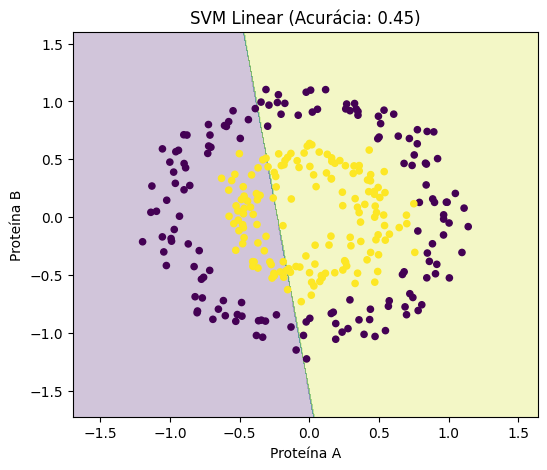

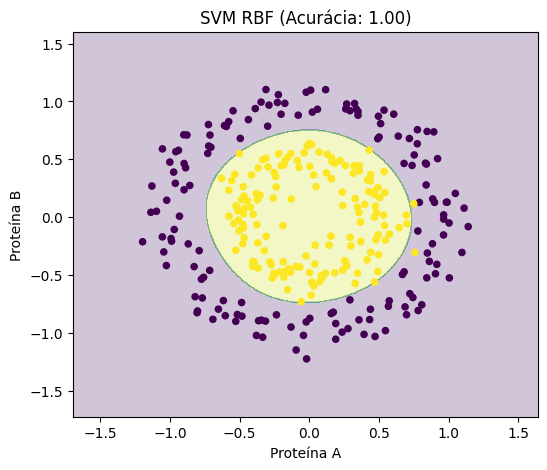


Matriz de Confusão - Linear
[[14 24]
 [17 20]]

Matriz de Confusão - RBF
[[38  0]
 [ 0 37]]

Relatório de Classificação - Linear
              precision    recall  f1-score   support

           0      0.452     0.368     0.406        38
           1      0.455     0.541     0.494        37

    accuracy                          0.453        75
   macro avg      0.453     0.454     0.450        75
weighted avg      0.453     0.453     0.449        75

Relatório de Classificação - RBF
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        38
           1      1.000     1.000     1.000        37

    accuracy                          1.000        75
   macro avg      1.000     1.000     1.000        75
weighted avg      1.000     1.000     1.000        75



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_csv('/mnt/data/01_imunoterapia_circulos.csv')
X = df[['proteina_A', 'proteina_B']]
y = df['resposta']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto'))
])

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

acc_linear = accuracy_score(y_test, y_pred_linear)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"Acurácia (Linear): {acc_linear:.3f}")
print(f"Acurácia (RBF)   : {acc_rbf:.3f}")

def plot_decision(model, X, y, title):
    x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
    y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )

    grid = pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()],
        columns=X.columns
    )
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=20)
    plt.xlabel("Proteína A")
    plt.ylabel("Proteína B")
    plt.title(title)
    plt.show()

plot_decision(svm_linear, X, y, f"SVM Linear (Acurácia: {acc_linear:.2f})")
plot_decision(svm_rbf, X, y, f"SVM RBF (Acurácia: {acc_rbf:.2f})")

cm_lin = confusion_matrix(y_test, y_pred_linear)
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

print("\nMatriz de Confusão - Linear")
print(cm_lin)
print("\nMatriz de Confusão - RBF")
print(cm_rbf)

print("\nRelatório de Classificação - Linear")
print(classification_report(y_test, y_pred_linear, digits=3))

print("Relatório de Classificação - RBF")
print(classification_report(y_test, y_pred_rbf, digits=3))

### Explicação dos Conceitos (Exercício 1)

* **Modelo(s):** SVM (Support Vector Machine) com kernel Linear e RBF (Radial Basis Function).
* **Conceitos:** Hiperplano e Vetores de Suporte.

**Explicação:**

* **Hiperplano:** Pense no hiperplano como um "critério de decisão" ou uma "fronteira diagnóstica" que o modelo SVM cria com base nos dados dos pacientes (níveis das `proteina_A` e `proteina_B`) para separar grupos diferentes (ex: respondedores vs. não respondedores à imunoterapia).
    * No **SVM Linear**, essa fronteira é uma linha reta. É como estabelecer um limiar simples baseado na combinação linear dos marcadores.
    * No **SVM com kernel RBF**, a fronteira é curva e flexível, criando "regiões" de classificação mais complexas no espaço dos biomarcadores. Útil quando a resposta ao tratamento depende de uma relação não linear entre as proteínas.
* **Vetores de Suporte:** São os "casos-limite" – os pacientes cujos dados (níveis de proteína) estão mais próximos da fronteira de decisão. São os pontos mais "difíceis" de classificar. Esses pacientes são cruciais porque definem onde a fronteira (hiperplano) deve passar para maximizar a separação entre os grupos.

## 2. O Mistério dos Ratinhos — SVM + Ajuste de Parâmetros

**Contexto:** Expressão gênica (500 features) para identificar o tratamento (A/B/C).

**Arquivo:** `/mnt/data/02_ratinhos_expressao_500genes.csv`

**Tarefas:**

1) Padronize as features (StandardScaler).

2) Use GridSearchCV para ajustar `C` e `gamma` do SVM (RBF).

3) Avalie com matriz de confusão e classificação por classe.


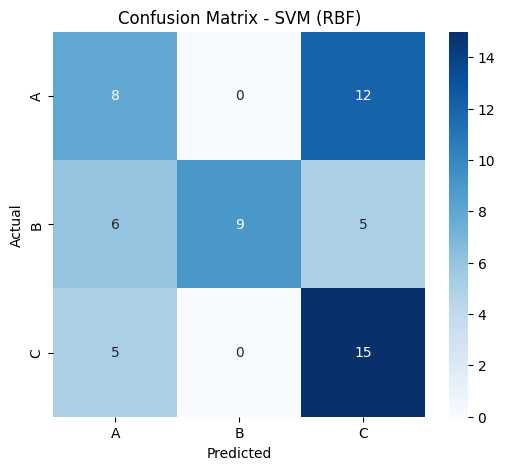

Melhores parâmetros encontrados: {'C': 1, 'gamma': 0.001}


,precision,recall,f1-score,support
A,0.42,0.40,0.41,20.00
B,1.00,0.45,0.62,20.00
C,0.47,0.75,0.58,20.00
accuracy,0.53,0.53,0.53,0.53
macro avg,0.63,0.53,0.54,60.00
weighted avg,0.63,0.53,0.54,60.00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/mnt/data/02_ratinhos_expressao_500genes.csv")
X = df.drop("tratamento", axis=1)
y = df["tratamento"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001]
}

svm = SVC(kernel="rbf")
grid = GridSearchCV(svm, param_grid, refit=True, cv=5, verbose=0)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid.classes_, yticklabels=grid.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (RBF)")
plt.show()

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
print("Melhores parâmetros encontrados:", grid.best_params_)
display(report_df)


## 3. As Folhas e o Gene Mutante — Árvore de Decisão

**Contexto:** Morfometria de folhas com marcador `mutante`.

**Arquivo:** `/mnt/data/03_folhas_morfometria.csv`

**Tarefas:**

1) Treine árvore usando critérios Gini e Entropia.

2) Visualize a árvore e interprete as divisões biológicas.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

dados = pd.read_csv("/mnt/data/03_folhas_morfometria.csv")
print("Primeiras linhas do dataset:")
print(dados.head())

X = dados.drop("mutante", axis=1)
y = dados["mutante"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tree_gini = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=4)
tree_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=4)

tree_gini.fit(X_train_scaled, y_train)
tree_entropy.fit(X_train_scaled, y_train)

print("\n=== RESULTADOS (GINI) ===")
print(classification_report(y_test, tree_gini.predict(X_test_scaled)))

print("\n=== RESULTADOS (ENTROPIA) ===")
print(classification_report(y_test, tree_entropy.predict(X_test_scaled)))

# Visualização mais simples (modo texto pq plot é feio)
print("\nRegras da Árvore (Gini):")
print(export_text(tree_gini, feature_names=list(X.columns)))



Primeiras linhas do dataset:
   comprimento   largura  razao_LW  mutante
0    10.993428  3.286230  3.345301        1
1     9.723471  3.448628  2.819519        0
2    11.295377  3.866441  2.921389        0
3    13.046060  3.843042  3.394722        1
4     9.531693  1.897865  5.022325        1
Tamanho treino: (140, 3)  | Tamanho teste: (60, 3)

=== RESULTADOS (GINI) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        32

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


=== RESULTADOS (ENTROPIA) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        32

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60

* **Modelo(s):** Árvore de Decisão (com critérios Gini e Entropia).
* **Conceito:** Interpretação das divisões biológicas.

**Explicação:**

* **Árvore de Decisão:** Imagine a árvore como um fluxograma diagnóstico. Ela faz perguntas sequenciais baseadas nas características da amostra (morfometria das folhas).
* **Divisões (Nós Internos):** Cada pergunta (ex: "`razao_LW` <= 3.2?") divide as amostras em dois grupos, buscando a melhor separação entre mutantes e não mutantes naquele ponto (usando Gini ou Entropia para medir a "pureza" da separação).
* **Folhas (Nós Terminais):** Representam a classificação final ('mutante' ou 'não mutante').
* **Interpretação Biológica:** As características e limiares nas divisões (especialmente perto da raiz) indicam os fatores morfométricos mais importantes para distinguir a condição 'mutante', como a `razao_LW` neste caso.

## 4. A Clínica dos Cães — Overfitting em Árvores

**Contexto:** Hipotireoidismo canino com rótulos ruidosos (10%).

**Arquivo:** `/mnt/data/04_caes_hipotireoidismo.csv`

**Tarefas:**

1) Treine árvore profunda vs. árvore podada (`max_depth`, `min_samples_leaf`).

2) Compare acurácia de treino e teste. Discuta overfitting.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('/mnt/data/04_caes_hipotireoidismo.csv')

X = df.drop(columns=['diagnostico'])
y = df['diagnostico']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

tree_deep = DecisionTreeClassifier(random_state=42)
tree_deep.fit(X_train, y_train)

tree_pruned = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=5, random_state=42
)
tree_pruned.fit(X_train, y_train)

y_pred_deep = tree_deep.predict(X_test)
y_pred_pruned = tree_pruned.predict(X_test)

acc_train_deep = accuracy_score(y_train, tree_deep.predict(X_train))
acc_test_deep  = accuracy_score(y_test, y_pred_deep)

acc_train_pruned = accuracy_score(y_train, tree_pruned.predict(X_train))
acc_test_pruned  = accuracy_score(y_test, y_pred_pruned)

print("=== Árvore Profunda ===")
print(f"Acurácia treino: {acc_train_deep:.3f}")
print(f"Acurácia teste : {acc_test_deep:.3f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred_deep))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_deep))

print("\n=== Árvore Podada ===")
print(f"Acurácia treino: {acc_train_pruned:.3f}")
print(f"Acurácia teste : {acc_test_pruned:.3f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_test, y_pred_pruned))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred_pruned))



=== Árvore Profunda ===
Acurácia treino: 1.000
Acurácia teste : 0.820

Matriz de confusão:
 [[33  6]
 [ 3  8]]

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        39
           1       0.57      0.73      0.64        11

    accuracy                           0.82        50
   macro avg       0.74      0.79      0.76        50
weighted avg       0.84      0.82      0.83        50


=== Árvore Podada ===
Acurácia treino: 0.887
Acurácia teste : 0.820

Matriz de confusão:
 [[35  4]
 [ 5  6]]

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        39
           1       0.60      0.55      0.57        11

    accuracy                           0.82        50
   macro avg       0.74      0.72      0.73        50
weighted avg       0.81      0.82      0.82        50



* **Modelo(s):** Árvore de Decisão (Profunda vs. Podada).
* **Conceito:** Overfitting.

**Explicação:**

* **Overfitting (Superajuste):** Ocorre quando o modelo (árvore profunda) aprende "bem demais" os dados de treino, incluindo ruídos (rótulos errados), ajustando-se perfeitamente a eles (ex: acurácia de treino 100%), mas perdendo a capacidade de generalizar para novos casos (acurácia de teste menor). É como uma regra clínica tão específica para os primeiros pacientes que falha em novos.
* **Árvore Podada (Regularização):** Limitar a complexidade da árvore (ex: `max_depth`, `min_samples_leaf`) a torna menos sensível ao ruído e a detalhes específicos do treino, focando em regras mais gerais e robustas. A acurácia no treino pode cair, mas a performance no teste tende a ser melhor ou igual, indicando melhor generalização.

## 5. Sequenciamento de Mistérios — Random Forest & Importância de Genes

**Contexto:** Expressão de 10.000 genes para diagnóstico binário.

**Arquivo:** `/mnt/data/05_alzheimer_10000genes.csv`

**Tarefas:**

1) Treine RandomForest e extraia `feature_importances_`.

2) Liste top-10 genes e discuta a relevância.


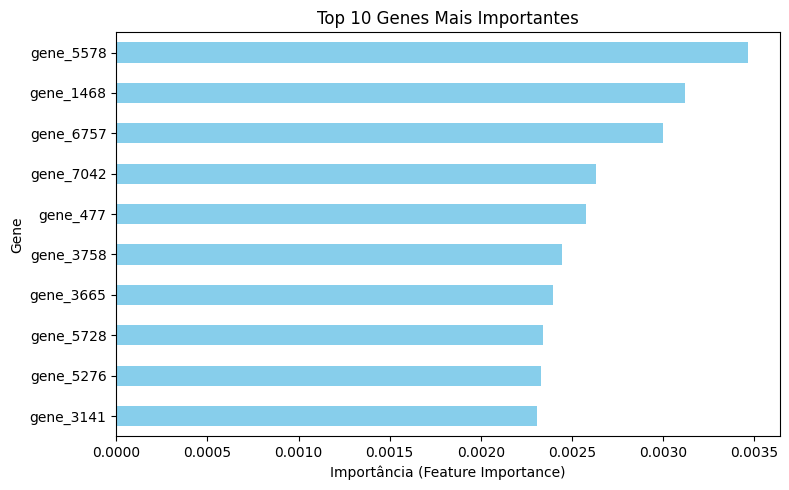

(              precision  recall  f1-score  support
 0                 0.432   0.673     0.526   52.000
 1                 0.564   0.324     0.411   68.000
 accuracy          0.475   0.475     0.475    0.475
 macro avg         0.498   0.498     0.469  120.000
 weighted avg      0.507   0.475     0.461  120.000,
 gene_5578    0.003468
 gene_1468    0.003119
 gene_6757    0.002998
 gene_7042    0.002632
 gene_477     0.002574
 gene_3758    0.002446
 gene_3665    0.002397
 gene_5728    0.002339
 gene_5276    0.002328
 gene_3141    0.002311
 dtype: float64)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

file_path = "/mnt/data/05_alzheimer_10000genes.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["diagnostico"])
y = df["diagnostico"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

importances = pd.Series(rf.feature_importances_, index=X.columns)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top10.sort_values().plot(kind="barh", color="skyblue")
plt.title("Top 10 Genes Mais Importantes")
plt.xlabel("Importância (Feature Importance)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

report.round(3).head(8), top10


* **Modelo(s):** Random Forest (Floresta Aleatória).
* **Conceitos:** Funcionamento do Random Forest e Importância de Variáveis (Feature Importance).

**Explicação:**

* **Random Forest:** É um "comitê" de muitas Árvores de Decisão. Cada árvore é treinada com uma amostra diferente dos dados e considera apenas um subconjunto aleatório de biomarcadores (genes) em cada decisão. A classificação final é por votação majoritária. Isso torna o modelo mais robusto e menos propenso a overfitting do que uma única árvore (similar a um diagnóstico por consenso).
* **Importância de Variáveis (Feature Importance):** Mede o quão útil cada biomarcador (gene) foi, em média, para as decisões corretas em todas as árvores do comitê. Genes com alta importância são os que mais ajudaram a separar os grupos (ex: Alzheimer vs. Controle). Identifica os biomarcadores potencialmente mais relevantes para o diagnóstico.

## 6. O Estudo das Abelhas — Bagging e Robustez

**Contexto:** Sobrevivência de colmeias no inverno.

**Arquivo:** `/mnt/data/06_abelhas_sobrevivencia.csv`

**Tarefas:**

1) Compare árvore única vs. RandomForest(100).

2) Discuta variância/estabilidade entre execuções.


Acurácia Árvore Única: 0.822
Acurácia Random Forest: 0.878


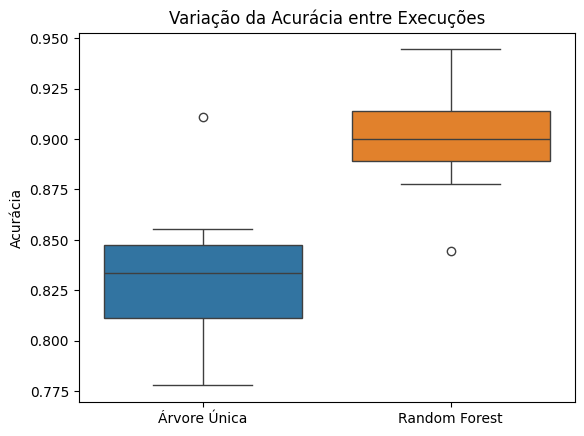


Média de Acurácia e Desvio Padrão:
      Árvore Única  Random Forest
mean      0.830556       0.902778
std       0.030774       0.021891


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = "/mnt/data/06_abelhas_sobrevivencia.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["sobreviveu"])
y = df["sobreviveu"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Árvore única
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)

# Floresta aleatória
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Acurácia Árvore Única: {acc_tree:.3f}")
print(f"Acurácia Random Forest: {acc_rf:.3f}")

runs = 20
acc_tree_list = []
acc_rf_list = []

for seed in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    tree = DecisionTreeClassifier(random_state=seed)
    rf = RandomForestClassifier(n_estimators=100, random_state=seed)
    tree.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    acc_tree_list.append(accuracy_score(y_test, tree.predict(X_test)))
    acc_rf_list.append(accuracy_score(y_test, rf.predict(X_test)))

accs = pd.DataFrame({
    "Árvore Única": acc_tree_list,
    "Random Forest": acc_rf_list
})

sns.boxplot(data=accs)
plt.title("Variação da Acurácia entre Execuções")
plt.ylabel("Acurácia")
plt.show()

print("\nMédia de Acurácia e Desvio Padrão:")
print(accs.describe().loc[["mean", "std"]])


* **Modelo(s):** Árvore de Decisão vs. Random Forest.
* **Conceito:** Variância/Estabilidade e Bagging.

**Explicação:**

* **Variância/Estabilidade:** Uma única Árvore de Decisão pode ser instável (alta variância) – pequenas mudanças nos dados de treino podem alterar drasticamente suas regras.
* **Bagging (Bootstrap Aggregating):** Técnica usada no Random Forest. Cria-se muitas amostras dos dados originais (com reposição - *bootstrap*), treina-se uma árvore em cada uma, e a previsão final é a média/voto da maioria. Isso reduz a variância, tornando o modelo (floresta) mais estável e robusto a pequenas alterações nos dados, similar à estabilidade de uma meta-análise comparada a um único estudo pequeno.

## 7. A Bactéria Rebelde — SVM Multiclasse

**Contexto:** Resistência antimicrobiana em E. coli (A/B/C).

**Arquivo:** `/mnt/data/07_ecoli_resistencia.csv`

**Tarefas:**

1) SVM multiclasse (one-vs-rest) com padronização.

2) Avalie precisão por classe e analise confusões.


=== Relatório de Classificação ===


,precision,recall,f1-score,support
A,0.697,0.767,0.730,30.000
B,0.758,0.833,0.794,30.000
C,0.917,0.733,0.815,30.000
accuracy,0.778,0.778,0.778,0.778
macro avg,0.790,0.778,0.780,90.000
weighted avg,0.790,0.778,0.780,90.000


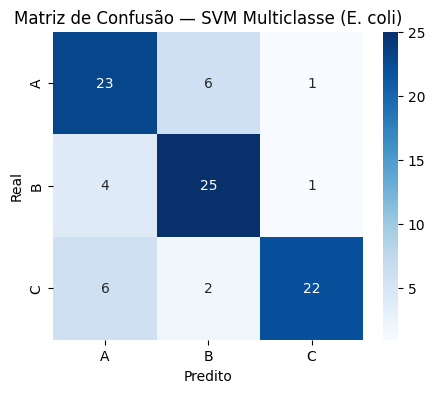

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/mnt/data/07_ecoli_resistencia.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["classe_resistencia"])
y = df["classe_resistencia"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel="rbf", decision_function_shape="ovr", random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("=== Relatório de Classificação ===")
display(report_df.round(3))

cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("Matriz de Confusão — SVM Multiclasse (E. coli)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


* **Modelo(s):** SVM Multiclasse (com estratégia One-vs-Rest - OvR).
* **Conceito:** Estratégia One-vs-Rest (OvR).

**Explicação:**

* **SVM Multiclasse (OvR):** Para classificar entre múltiplas classes (A, B, C) com um modelo binário como o SVM, a estratégia "Um-contra-o-Resto" (OvR) treina classificadores separados:
    1.  Um SVM para A vs. (B+C).
    2.  Um SVM para B vs. (A+C).
    3.  Um SVM para C vs. (A+B).
* Uma nova amostra é avaliada pelos três SVMs. A classe cujo SVM correspondente der a maior pontuação de confiança é a escolhida. É como ter testes diagnósticos específicos para cada tipo de resistência.

## 8. O Julgamento dos Médicos — Árvore Explicável

**Contexto:** Risco cardiovascular com regras clínicas simples.

**Arquivo:** `/mnt/data/08_risco_cardiovascular.csv`

**Tarefas:**

1) Árvore rasa (profundidade ≤ 3) e extração de regras.

2) Apresente as regras como relatório clínico.


=== Relatório de Classificação ===


,precision,recall,f1-score,support
0,0.957,0.985,0.971,67.000
1,0.833,0.625,0.714,8.000
accuracy,0.947,0.947,0.947,0.947
macro avg,0.895,0.805,0.842,75.000
weighted avg,0.943,0.947,0.943,75.000


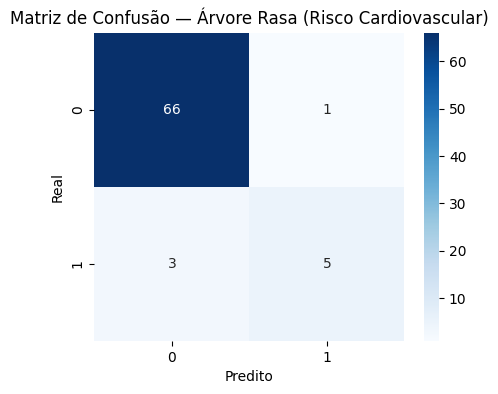


Relatório Clínico
|--- colesterol <= 238.84
|   |--- pressao <= 135.11
|   |   |--- class: 0
|   |--- pressao >  135.11
|   |   |--- bmi <= 29.81
|   |   |   |--- class: 0
|   |   |--- bmi >  29.81
|   |   |   |--- class: 1
|--- colesterol >  238.84
|   |--- idade <= 58.00
|   |   |--- pressao <= 152.87
|   |   |   |--- class: 0
|   |   |--- pressao >  152.87
|   |   |   |--- class: 1
|   |--- idade >  58.00
|   |   |--- class: 1



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_text

file_path = "/mnt/data/08_risco_cardiovascular.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["risco"])
y = df["risco"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("=== Relatório de Classificação ===")
display(report_df.round(3))

cm = confusion_matrix(y_test, y_pred, labels=tree.classes_)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tree.classes_, yticklabels=tree.classes_)
plt.title("Matriz de Confusão — Árvore Rasa (Risco Cardiovascular)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

from sklearn.tree import export_text

rules = export_text(tree, feature_names=list(X.columns))
rules_path = "/mnt/data/regras_arvore_simples_risco.txt"
with open(rules_path, "w", encoding="utf-8") as f:
    f.write(rules)

rules_path

rules = export_text(tree, feature_names=list(X.columns))
print("\nRelatório Clínico")
for line in rules.split("\n"):
    print(line)


* **Modelo(s):** Árvore de Decisão Rasa (Podada).
* **Conceito:** Extração de Regras para Relatório Clínico.

**Explicação:**

* **Extração de Regras:** Uma árvore de decisão rasa (`max_depth` pequeno) é facilmente traduzida em regras "SE-ENTÃO" compreensíveis, como diretrizes clínicas:
    * "SE `colesterol` <= 238.84 E SE `pressao` <= 135.11 ENTÃO Risco Cardiovascular = 0 (Baixo)"
    * "SE `colesterol` > 238.84 E SE `idade` > 58.0 ENTÃO Risco Cardiovascular = 1 (Alto)"
* A simplicidade facilita a comunicação e a interpretabilidade do modelo no contexto clínico.

## 9. O Sensor Fantasma — Random Forest com Ruído

**Contexto:** Sensor de glicose com rótulos corrompidos (~15%).

**Arquivo:** `/mnt/data/09_sensor_glicose_ruido.csv`

**Tarefas:**

1) Treine RandomForest; avalie AUC, sensibilidade e especificidade.

2) Discuta robustez a outliers e leituras erráticas.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

df = pd.read_csv('/mnt/data/09_sensor_glicose_ruido.csv')
X = df.drop(columns=['alerta', 'paciente_id'])
y = df['alerta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\n--- Resultados da Avaliação ---")
print(f"Out-of-Bag (OOB) Score: {rf_model.oob_score_:.4f}")
print(f"ROC AUC: {auc:.4f}")
print(f"Sensibilidade (Recall): {sensitivity:.4f}")
print(f"Especificidade: {specificity:.4f}")
print("\nMatriz de Confusão:")
print(f"Verdadeiros Positivos (Alertas Corretos): {tp}")
print(f"Falsos Positivos (Alarmes Falsos): {fp}")
print(f"Verdadeiros Negativos (Normais Corretos): {tn}")
print(f"Falsos Negativos (Alertas Perdidos): {fn}")


--- Resultados da Avaliação ---
Out-of-Bag (OOB) Score: 0.8044
ROC AUC: 0.8435
Sensibilidade (Recall): 0.7027
Especificidade: 0.8158

Matriz de Confusão:
Verdadeiros Positivos (Alertas Corretos): 26
Falsos Positivos (Alarmes Falsos): 7
Verdadeiros Negativos (Normais Corretos): 31
Falsos Negativos (Alertas Perdidos): 11


* **Modelo(s):** Random Forest.
* **Conceito:** Robustez a outliers e ruído.

**Explicação:**

* **Robustez a Ruído/Outliers:** O Random Forest é mais resistente a dados ruidosos (rótulos incorretos) e outliers (leituras erráticas do sensor) do que uma única árvore ou SVMs (dependendo da configuração). Isso se deve ao *Bagging* (cada árvore vê parte dos dados, diluindo erros) e à votação majoritária (que "cancela" previsões erradas de árvores individuais). Leituras extremas também têm impacto limitado devido à agregação. É adequado para dados biológicos/sensores com potenciais erros. O score OOB ajuda a estimar a generalização.

## 10. A Guerra dos Modelos — Comparativo

**Contexto:** Mortalidade em UTI com 20 variáveis.

**Arquivo:** `/mnt/data/10_uti_mortalidade_20vars.csv`

**Tarefas:**

1) Compare SVM, Árvore e RandomForest (AUC, F1, recall, precisão).

2) Justifique a escolha do melhor modelo considerando desempenho e interpretabilidade.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/mnt/data/10_uti_mortalidade_20vars.csv')
X = df.drop(columns=['mortalidade'])
y = df['mortalidade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
svm_auc = roc_auc_score(y_test, y_proba_svm)

print(f"ROC AUC do SVM: {svm_auc:.4f}")
print("Relatório de Classificação do SVM:")
print(classification_report(y_test, y_pred_svm))

tree_model = DecisionTreeClassifier(random_state=42)

tree_model.fit(X_train_scaled, y_train)
y_pred_tree = tree_model.predict(X_test_scaled)
y_proba_tree = tree_model.predict_proba(X_test_scaled)[:, 1]

tree_auc = roc_auc_score(y_test, y_proba_tree)
print(f"ROC AUC da Árvore: {tree_auc:.4f}")
print("Relatório de Classificação da Árvore:")
print(classification_report(y_test, y_pred_tree))


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]


rf_auc = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC do Random Forest: {rf_auc:.4f}")
print("Relatório de Classificação do Random Forest:")
print(classification_report(y_test, y_pred_rf))

f1_svm = classification_report(y_test, y_pred_svm, output_dict=True)['1']['f1-score']
f1_tree = classification_report(y_test, y_pred_tree, output_dict=True)['1']['f1-score']
f1_rf = classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score']

print("\n\n--- RESULTADO FINAL DA GUERRA DOS MODELOS ---")
print("-" * 50)
print(f"{'Modelo':<20} | {'ROC AUC':<10} | {'F1-Score (Morte)':<15}")
print("-" * 50)
print(f"{'SVM':<20} | {svm_auc:<10.4f} | {f1_svm:<15.4f}")
print(f"{'Árvore de Decisão':<20} | {tree_auc:<10.4f} | {f1_tree:<15.4f}")
print(f"{'Random Forest':<20} | {rf_auc:<10.4f} | {f1_rf:<15.4f}")
print("-" * 50)

ROC AUC do SVM: 0.9680
Relatório de Classificação do SVM:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        50
           1       0.84      0.96      0.90        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

ROC AUC da Árvore: 0.8300
Relatório de Classificação da Árvore:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        50
           1       0.81      0.86      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

ROC AUC do Random Forest: 0.9504
Relatório de Classificação do Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        50
           1       0.87      0.96    

* **Modelo(s):** SVM, Árvore de Decisão, Random Forest.
* **Conceito:** Comparação e Justificativa da Escolha do Modelo.

**Explicação (Linguagem Biomédica):**

* **Comparação:** Avaliamos qual modelo prevê melhor a mortalidade na UTI.
    * **SVM:** Pode ter alta performance (bom AUC), mas é menos interpretável ("caixa-preta").
    * **Árvore de Decisão:** Altamente interpretável (regras claras), mas pode ser menos precisa/estável.
    * **Random Forest:** Geralmente alta performance (bom AUC/F1), mais robusto que a árvore, e oferece interpretabilidade média (importância das variáveis).
* **Justificativa:**
    * Para **máxima precisão**, SVM ou RF.
    * Para **máxima interpretabilidade**, Árvore (talvez podada).
    * O **Random Forest** costuma ser um bom **compromisso** entre performance e alguma explicação (via importância das variáveis clínicas). No seu caso, o RF teve o melhor F1-Score para a classe de mortalidade, indicando bom equilíbrio preditivo.

## Bônus 1. O Diagnóstico Raro — AdaBoost

**Contexto:** Doença rara (3% de prevalentes), forte desbalanceamento.

**Arquivo:** `/mnt/data/B1_doenca_rara_desbalanceado.csv`

**Tarefas:**

1) AdaBoost com árvores fracas (max_depth=1).

2) Analise `n_estimators` e `learning_rate` sob métricas sensíveis à minoria (AUC-PR, recall positivo).


In [ ]:
# Passo 1: Importar as bibliotecas necessárias
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score, classification_report, recall_score
import numpy as np # Import numpy for potential thresholding analysis later if needed

# Passo 2: Carregar e preparar os dados
df = pd.read_csv('/mnt/data/B1_doenca_rara_desbalanceado.csv')
X = df.drop(columns=['doenca_rara'])
y = df['doenca_rara']

# Passo 3: Dividir os dados em treino e teste (antes do SMOTE)
# Mantém o teste original desbalanceado para avaliação realista.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Passo 4: Aplicar SMOTE APENAS no conjunto de treino
print("Formato antes do SMOTE:", X_train.shape, y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Formato depois do SMOTE:", X_train_res.shape, y_train_res.value_counts())
print("-" * 50) # Separador visual

# Passo 5: Definir os parâmetros para análise
# Listas de valores para n_estimators e learning_rate a serem testados
n_estimators_list = [50, 100, 200, 300, 500, 800]
learning_rate_list = [0.01, 0.05, 0.1, 0.5, 1.0]

# Lista para armazenar os resultados da análise
results = []

# Passo 6: Iterar pelos parâmetros, treinar e avaliar
print("Iniciando análise de parâmetros para AdaBoost...")

for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        # Define o estimador base (árvore fraca)
        base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

        # Configura o modelo AdaBoost com os parâmetros da iteração atual
        ada_model = AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )

        # Treina o modelo com os dados de treino balanceados
        ada_model.fit(X_train_res, y_train_res)

        # Faz previsões e calcula probabilidades no teste original desbalanceado
        y_pred = ada_model.predict(X_test)
        # Tenta obter probabilidades, trata caso não seja possível (raro com AdaBoost)
        try:
             y_proba = ada_model.predict_proba(X_test)[:, 1]
             auc_pr = average_precision_score(y_test, y_proba)
        except AttributeError:
             y_proba = None
             auc_pr = float('nan') # Marca como NaN se não puder calcular probas


        # Extrai o recall da classe positiva (classe 1) do relatório
        # Usa recall_score diretamente para simplificar e garantir que pegamos o da classe 1
        recall_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)


        # Armazena os resultados
        results.append({
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'AUC_PR': auc_pr,
            'Recall_Class_1': recall_pos
        })

        # Opcional: Imprimir progresso
        # print(f"  Testado: n_est={n_estimators}, lr={learning_rate} -> AUC-PR={auc_pr:.4f}, Recall_1={recall_pos:.4f}")

print("Análise de parâmetros concluída.")
print("-" * 50)

# Passo 7: Apresentar os resultados da análise
results_df = pd.DataFrame(results)

# Ordenar os resultados pelo AUC-PR (do maior para o menor) para ver os melhores
results_df_sorted = results_df.sort_values(by='AUC_PR', ascending=False)

print("\n--- Resultados da Análise de Parâmetros (Ordenado por AUC-PR) ---")
# Exibe o DataFrame com os resultados formatados
# Usamos display para melhor formatação no Colab/Jupyter
from IPython.display import display
display(results_df_sorted.round(4))

print("\n--- Melhor Combinação Encontrada (Baseado no AUC-PR) ---")
best_params = results_df_sorted.iloc[0]
print(f"n_estimators: {best_params['n_estimators']}")
print(f"learning_rate: {best_params['learning_rate']}")
print(f"Melhor AUC-PR: {best_params['AUC_PR']:.4f}")
print(f"Recall Classe 1 (com esses params): {best_params['Recall_Class_1']:.4f}")

# Opcional: Treinar e mostrar o relatório completo do melhor modelo encontrado
print("\n--- Relatório de Classificação do Melhor Modelo ---")
best_n_estimators = int(best_params['n_estimators'])
best_learning_rate = best_params['learning_rate']

best_base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
best_ada_model = AdaBoostClassifier(
    estimator=best_base_estimator,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42
)
best_ada_model.fit(X_train_res, y_train_res)
best_y_pred = best_ada_model.predict(X_test)
print(classification_report(y_test, best_y_pred, zero_division=0))

Formato antes do SMOTE: (750, 12) doenca_rara
0    724
1     26
Name: count, dtype: int64
Formato depois do SMOTE: (1448, 12) doenca_rara
0    724
1    724
Name: count, dtype: int64
--------------------------------------------------
Iniciando análise de parâmetros para AdaBoost...
Análise de parâmetros concluída.
--------------------------------------------------

--- Resultados da Análise de Parâmetros (Ordenado por AUC-PR) ---


,n_estimators,learning_rate,AUC_PR,Recall_Class_1
9,100,1.00,0.4195,0.6667
19,300,1.00,0.4016,0.5556
14,200,1.00,0.3926,0.6667
4,50,1.00,0.3902,0.7778
18,300,0.50,0.3493,0.6667
29,800,1.00,0.3391,0.5556
27,800,0.10,0.3321,0.6667
8,100,0.50,0.3262,0.7778
24,500,1.00,0.3251,0.5556
13,200,0.50,0.3176,0.6667



--- Melhor Combinação Encontrada (Baseado no AUC-PR) ---
n_estimators: 100.0
learning_rate: 1.0
Melhor AUC-PR: 0.4195
Recall Classe 1 (com esses params): 0.6667

--- Relatório de Classificação do Melhor Modelo ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       241
           1       0.21      0.67      0.32         9

    accuracy                           0.90       250
   macro avg       0.60      0.79      0.64       250
weighted avg       0.96      0.90      0.92       250



### Bônus 1 - Análise de Parâmetros do AdaBoost com SMOTE

Este bloco de código realiza a **análise dos hiperparâmetros `n_estimators` e `learning_rate`** para o classificador **AdaBoost** no contexto do **Bônus 1 (Diagnóstico Raro)**, que lida com um dataset **fortemente desbalanceado**. Ele utiliza **SMOTE** para balancear o conjunto de treino e avalia o desempenho focando em métricas sensíveis à classe minoritária.

**Passos Principais:**

1.  **Importações:** Carrega as bibliotecas necessárias, incluindo `SMOTE`, `pandas`, `train_test_split`, `AdaBoostClassifier`, `DecisionTreeClassifier` (como árvore fraca), e métricas (`average_precision_score`, `classification_report`, `recall_score`).
2.  **Carga e Divisão:** Lê o dataset `B1_doenca_rara_desbalanceado.csv`, separa features (`X`) e alvo (`y`), e divide os dados em treino e teste **antes** do SMOTE, usando `stratify=y` para manter a proporção de classes no teste.
3.  **Balanceamento SMOTE (Treino):** Aplica SMOTE **apenas no conjunto de treino** para criar amostras sintéticas da classe minoritária, gerando `X_train_res` e `y_train_res` balanceados.
4.  **Definição da Análise:** Cria listas de valores a serem testados para `n_estimators` (número de árvores fracas) e `learning_rate` (taxa de aprendizado). Inicializa uma lista `results` para guardar os desempenhos.
5.  **Loop de Análise:**
    * Itera sobre **todas as combinações** dos parâmetros definidos (`n_estimators` e `learning_rate`).
    * Dentro do loop, para cada combinação:
        * Configura um `AdaBoostClassifier` usando `DecisionTreeClassifier(max_depth=1)` como `estimator` (árvore fraca).
        * **Treina** o modelo nos dados de treino **balanceados pelo SMOTE**.
        * **Avalia** o modelo no conjunto de teste **original (desbalanceado)**.
        * Calcula o **AUC-PR** (Area Under Precision-Recall Curve), métrica robusta para desbalanceamento.
        * Calcula o **Recall da Classe 1** (sensibilidade para a doença rara) usando `recall_score`.
        * Armazena os parâmetros e as métricas calculadas na lista `results`.
6.  **Apresentação dos Resultados:**
    * Converte a lista `results` em um DataFrame do Pandas.
    * **Ordena** o DataFrame pelo `AUC_PR` em ordem decrescente.
    * **Exibe** a tabela ordenada, mostrando o `AUC_PR` e o `Recall_Class_1` para cada combinação de `n_estimators` e `learning_rate`.
    * Identifica e imprime a **melhor combinação** de parâmetros com base no maior AUC-PR.
    * (Opcional) Retreina o modelo com os melhores parâmetros e exibe o `classification_report` completo para essa configuração.

**Objetivo:** Analisar sistematicamente como `n_estimators` e `learning_rate` influenciam a capacidade do AdaBoost (com árvores fracas e treino balanceado por SMOTE) de identificar corretamente a classe minoritária (doença rara), utilizando AUC-PR e Recall positivo como principais indicadores de desempenho.

## Bônus 2. A Corrida dos Genomas — Gradient Boosting / XGBoost

**Contexto:** Classificação de origem geográfica com 500 SNPs.

**Arquivo:** `/mnt/data/B2_genomas_snps_500.csv`

**Tarefas:**

1) Treine GradientBoosting (ou XGBoost se disponível) com early stopping.

2) Compare com RandomForest e discuta trade-offs.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

df = pd.read_csv('/mnt/data/B2_genomas_snps_500.csv')

X = df.drop(columns=['origem'])
y = df['origem']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

gbm = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    validation_fraction=0.1,
    n_iter_no_change=5,
    tol=0.01,
    random_state=42
)

gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)
print(classification_report(y_test, y_pred_gbm))


print("\n--- Treinando o Random Forest para Comparação ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)
print("\nRelatório de Classificação do Random Forest:")
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         AFR       0.11      0.08      0.10        12
         AMR       0.30      0.23      0.26        13
         EAS       0.08      0.08      0.08        12
         EUR       0.16      0.23      0.19        13

    accuracy                           0.16        50
   macro avg       0.16      0.16      0.16        50
weighted avg       0.17      0.16      0.16        50


--- Treinando o Random Forest para Comparação ---

Relatório de Classificação do Random Forest:
              precision    recall  f1-score   support

         AFR       0.00      0.00      0.00        12
         AMR       0.44      0.31      0.36        13
         EAS       0.27      0.25      0.26        12
         EUR       0.43      0.46      0.44        13

    accuracy                           0.26        50
   macro avg       0.29      0.25      0.27        50
weighted avg       0.29      0.26      0.27        50



* **Modelo(s):** Gradient Boosting Machine (GBM) com Early Stopping, comparado com Random Forest (RF).
* **Conceitos:** Funcionamento do Gradient Boosting, Early Stopping, Comparação com Random Forest, Trade-offs.

**Explicação (Linguagem Biomédica):**

1.  **Gradient Boosting (GBM):** 🧬
    * Assim como o AdaBoost, o GBM constrói modelos (geralmente árvores) **sequencialmente**. No entanto, em vez de ajustar os pesos das amostras (pacientes/genomas), cada nova árvore tenta corrigir os *erros residuais* (a diferença entre a previsão atual e a origem geográfica real) do modelo combinado até o momento.
    * Ele faz isso seguindo o "gradiente" da função de erro, buscando a direção que mais reduz o erro a cada passo. Pense nisso como refinar progressivamente um escore de risco genético ou uma assinatura de expressão, onde cada novo marcador (árvore) adicionado foca em corrigir as falhas das previsões anteriores.

2.  **Early Stopping (Parada Antecipada):** ⏱️
    * Boosting (como GBM) pode sofrer de *overfitting* se muitas árvores forem adicionadas. O modelo pode começar a memorizar o ruído específico dos dados de treino.
    * *Early stopping* é uma técnica para evitar isso. Durante o treino, o GBM separa uma pequena parte dos dados de treino (`validation_fraction=0.1`) para monitorar o desempenho.
    * Ele verifica se a performance nesse conjunto de validação continua melhorando. Se a performance **não melhorar** por um certo número de rodadas consecutivas (`n_iter_no_change=5`), o treinamento é **interrompido** antes de atingir o `n_estimators` total (500, neste caso).
    * É como monitorar a resposta de um paciente a um tratamento ao longo do tempo e interromper ou ajustar a dose se não houver melhora observada após algumas avaliações. Isso evita "supertratar" o modelo.

3.  **Random Forest (RF) - Comparativo:**
    * Lembre-se (do Exercício 5) que o RF treina muitas árvores **em paralelo**, cada uma em uma amostra *bootstrap* dos dados e considerando um subconjunto aleatório de SNPs em cada divisão. A previsão final é por votação.
    * Isso o torna inerentemente bom em **reduzir a variância** e geralmente robusto a overfitting, sem a necessidade explícita de *early stopping* (embora o número de árvores ainda seja um parâmetro).

4.  **Trade-offs (GBM vs. RF):**
    * **Performance:** GBM (especialmente variantes como XGBoost ou LightGBM) muitas vezes consegue **maior precisão preditiva** que o RF *se bem ajustado*, pois foca sequencialmente na correção dos erros. No entanto, o RF pode ser mais robusto "de cara", sem tanto ajuste fino. Neste caso específico com 500 SNPs, o RF pode ter uma ligeira vantagem inicial se o GBM não for bem tunado.
    * **Overfitting:** GBM é **mais propenso a overfitting** que RF se não for regularizado (com `learning_rate` baixo, `max_depth` limitado, subamostragem, e *early stopping*). RF é naturalmente mais resistente devido ao *bagging* e aleatorização.
    * **Ajuste de Hiperparâmetros:** GBM geralmente requer **mais cuidado no ajuste** de parâmetros (`n_estimators`, `learning_rate`, `max_depth`, `subsample`, etc.) para obter o melhor desempenho. RF é muitas vezes mais "tolerante" a parâmetros padrão.
    * **Velocidade de Treino:** RF pode ser treinado **em paralelo** (cada árvore é independente), o que pode ser mais rápido em máquinas com múltiplos núcleos. GBM é inerentemente **sequencial**, embora implementações modernas usem paralelismo dentro da construção de cada árvore.
    * **Interpretabilidade:** Ambos oferecem métricas de **importância de features** (SNPs), ajudando a identificar os marcadores genéticos mais relevantes para distinguir as origens geográficas. A interpretabilidade direta das regras (como em uma árvore única) é perdida em ambos.

**Conclusão para o Bônus 2:** O código treina ambos os modelos. Ao comparar os `classification_report`s, você pode analisar qual obteve melhor precisão, recall e F1-score para cada origem geográfica (AFR, AMR, EAS, EUR). O GBM, com *early stopping*, tenta equilibrar a busca por performance com a prevenção de overfitting. O RF oferece uma alternativa robusta. A escolha entre eles dependeria do desempenho observado e da necessidade (ou tempo disponível) para ajuste fino de hiperparâmetros.